## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import os
root ='../input/german-single-speaker-speech-dataset'

In [2]:
os.listdir(root)

['achtgesichterambiwasse',
 'meisterfloh',
 'de',
 'transcript.txt',
 'serapionsbruederauswahl']

In [3]:
data = pd.read_csv(os.path.join(root, 'transcript.txt'), sep='|', header=None)
data.columns = ['Audio', 'Text_og', 'Text_norm', 'Duration']
# Sampling only 2000 files
df = data.iloc[:2000].reset_index(drop=True)
df['Audio'] = root + '/' + df['Audio']
df

,Audio,Text_og,Text_norm,Duration
0,../input/german-single-speaker-speech-dataset/...,"Hanake hatte allen Körperschmuck, den ein japa...","Hanake hatte allen Körperschmuck, den ein japa...",7.48
1,../input/german-single-speaker-speech-dataset/...,um zu den göttlichen Schönheiten der Vergängli...,um zu den göttlichen Schönheiten der Vergängli...,8.43
2,../input/german-single-speaker-speech-dataset/...,ihre Arme kurz wie die Flügel eines noch nicht...,ihre Arme kurz wie die Flügel eines noch nicht...,8.57
3,../input/german-single-speaker-speech-dataset/...,so arbeitete sie vorsichtig wie unter einer Gl...,so arbeitete sie vorsichtig wie unter einer Gl...,9.88
4,../input/german-single-speaker-speech-dataset/...,"so war sie unauffällig, als hätte sich ihr Kör...","so war sie unauffällig, als hätte sich ihr Kör...",5.65
...,...,...,...,...
1995,../input/german-single-speaker-speech-dataset/...,In einem roten mächtigen Holzbalkenhaus sitzt ...,In einem roten mächtigen Holzbalkenhaus sitzt ...,5.26
1996,../input/german-single-speaker-speech-dataset/...,"alt und schwerfällig geschnitzt, bräunlich ver...","alt und schwerfällig geschnitzt, bräunlich ver...",6.93
1997,../input/german-single-speaker-speech-dataset/...,Sein runder Kopf reicht bis unter das Dach des...,Sein runder Kopf reicht bis unter das Dach des...,7.73
1998,../input/german-single-speaker-speech-dataset/...,Aber das Licht von den Wiesen draußen kann den...,Aber das Licht von den Wiesen draußen kann den...,9.65


### Remoning Punctuations

In [4]:
import re
import string
#from nltk.corpus import stopwords

In [5]:
#stopwords_list = stopwords.words('german')
def preprocess(text):
    text = re.sub(r'[.`"|\/?,!@$%^&*]', '', text.lower())
    #text = [''.join(i) for i in text.split() if i not in stopwords_list]
    return text

In [6]:
df['Text_norm_2'] = df['Text_norm'].apply(preprocess)

### Extracting MFCC features

In [7]:
import librosa

In [62]:
def mfcc_feature(audio_file):
    mfccs = list()
    try:
        x, sr = librosa.load(audio_file)
        mfccs = librosa.feature.mfcc(y = x, sr = sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T, axis=0)
    except:
        print('Error reading file')
    return mfccs.reshape(16,8,1)

In [9]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [11]:
mfcc_list = list()
[mfcc_list.append(mfcc_feature(i)) for i in tqdm(df['Audio'])];

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
df['mfcc'] = mfcc_list
df.drop(['Audio', 'Text_og', 'Text_norm', 'Duration'], axis=1, inplace=True)
df.columns = ['Text', 'MFCC']

In [13]:
df

,Text,MFCC
0,hanake hatte allen körperschmuck den ein japan...,"[[[-345.88925], [79.0515], [-2.4584749], [36.2..."
1,um zu den göttlichen schönheiten der vergängli...,"[[[-369.35767], [79.29271], [3.954758], [33.83..."
2,ihre arme kurz wie die flügel eines noch nicht...,"[[[-378.45963], [71.2127], [4.663769], [30.625..."
3,so arbeitete sie vorsichtig wie unter einer gl...,"[[[-370.27963], [76.10787], [6.1174717], [29.1..."
4,so war sie unauffällig als hätte sich ihr körp...,"[[[-367.811], [76.37388], [9.039551], [31.6433..."
...,...,...
1995,in einem roten mächtigen holzbalkenhaus sitzt ...,"[[[-346.06265], [93.86096], [3.4914272], [20.2..."
1996,alt und schwerfällig geschnitzt bräunlich verg...,"[[[-364.0426], [83.111626], [-0.46456572], [17..."
1997,sein runder kopf reicht bis unter das dach des...,"[[[-361.35275], [77.583015], [1.1958463], [18...."
1998,aber das licht von den wiesen draußen kann den...,"[[[-385.13254], [70.803764], [3.4824858], [25...."


In [14]:
df['MFCC'][0].shape

(16, 8, 1)

### Tokenizing

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [16]:
df['Text'][0]

'hanake hatte allen körperschmuck den ein japanisches mädchen sitzend trippelnd und liegend zeigen muß'

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'].values)
vocab_size = len(tokenizer.word_index)+1
max_length = df['Text'].apply(lambda x: len(x.split(" "))).max()

### Creating features

In [34]:
feature_mfcc = list()
feature_text = list()
response = list()
for i in range(len(df)):
    sequence = tokenizer.texts_to_sequences([df['Text'][i]])[0]
    for j in range(1,len(sequence)):
        in_seq, out_seq = sequence[:j], sequence[j]
        in_seq = pad_sequences([in_seq], maxlen=max_length)
        out_seq = to_categorical([out_seq], num_classes=vocab_size)
        
        feature_mfcc.append(df['MFCC'][i])
        feature_text.append(in_seq)
        response.append(out_seq)

In [35]:
feature_mfcc = np.array(feature_mfcc)
feature_text = (np.array(feature_text).reshape((np.shape(feature_text)[0], np.shape(feature_text)[2])))
response = (np.array(response)).reshape(np.shape(response)[0], np.shape(response)[2])

feature_mfcc.shape, feature_text.shape, response.shape

((30372, 16, 8, 1), (30372, 42), (30372, 5754))

In [36]:
split = int(len(df['Text'])*0.8)
X_train = [feature_mfcc[:split],feature_text[:split]]
y_train = response[:split]

X_test = [feature_mfcc[split:],feature_text[split:]]
y_test = response[split:]

## Model


In [37]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.layers import Embedding, LSTM, add#, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [38]:
input1 = Input(shape=(16,8,1), name='MFCC')
input2 = Input(shape=(max_length,), name='Padded Sequence')

model_mfcc = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same", name='Conv2D_1')(input1)
model_mfcc = MaxPooling2D((2, 2), name='Max_Pool_1')(model_mfcc)
model_mfcc = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding = "same", name='Conv2D_2')(model_mfcc)
model_mfcc = MaxPooling2D((2, 2), name='Max_Pool_2')(model_mfcc)
model_mfcc = Flatten(name='Flatten')(model_mfcc)
model_mfcc = Dense(128, activation='relu', name='Dense_1')(model_mfcc)
#feature_model_reshaped = Reshape((1, 128), input_shape=(128,))(model_mfcc)

model_text = Embedding(vocab_size, 128, mask_zero=False, name='Embedding_1')(input2)
model_text = LSTM(128, name='LSTM_1')(model_text)
model_text  = Dropout(0.5, name='Dropout_1')(model_text)

model_merge = add([model_text, model_mfcc], name='Merge_Node')
model_merge = Dense(128, activation='relu', name='Dense_2')(model_merge)
model_merge = Dropout(0.5, name='Dropout_2')(model_merge)
output = Dense(vocab_size, activation='softmax', name='Dense_3_Output')(model_merge)

model = Model(inputs=[input1,input2], outputs=output)
model.compile(loss='categorical_crossentropy',optimizer='adam')

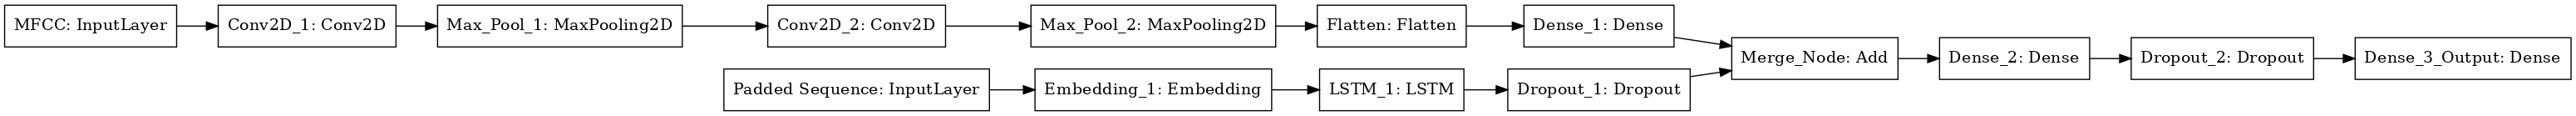

In [39]:
plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=False,
    dpi=100,
    layer_range=None,
)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
callback = EarlyStopping(monitor='loss', patience=2)

In [42]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test), callbacks=callback)

2022-10-24 06:28:54.684513: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
50/50 [==============================] - 21s 377ms/step - loss: 7.6461 - val_loss: 7.4096
Epoch 2/100
50/50 [==============================] - 19s 378ms/step - loss: 6.5127 - val_loss: 7.4975
Epoch 3/100
50/50 [==============================] - 18s 365ms/step - loss: 6.2652 - val_loss: 7.6612
Epoch 4/100
50/50 [==============================] - 20s 401ms/step - loss: 6.1647 - val_loss: 7.6436
Epoch 5/100
50/50 [==============================] - 18s 369ms/step - loss: 6.0143 - val_loss: 7.6229
Epoch 6/100
50/50 [==============================] - 19s 380ms/step - loss: 5.9418 - val_loss: 7.7672
Epoch 7/100
50/50 [==============================] - 19s 385ms/step - loss: 5.8208 - val_loss: 8.1004
Epoch 8/100
50/50 [==============================] - 18s 366ms/step - loss: 5.6733 - val_loss: 8.0163
Epoch 9/100
50/50 [==============================] - 18s 374ms/step - loss: 5.5830 - val_loss: 8.1537
Epoch 10/100
50/50 [==============================] - 18s 357ms/step - loss: 5.523

## Prediction

In [53]:
Test = data[2000:2010].reset_index(drop=True)
#test_list = list()
#[test_list.append(mfcc(i)) for i in tqdm(df['Audio'])];

In [54]:
#Test['mfcc'] = mfcc_list
Test['Text_norm_2'] = Test['Text_norm'].apply(preprocess)
Test.drop(['Text_og', 'Text_norm', 'Duration'], axis=1, inplace=True)
Test.columns = ['Audio', 'Text']
Test['Audio'] = root + '/' + Test['Audio']

In [55]:
Test

,Audio,Text
0,../input/german-single-speaker-speech-dataset/...,und vertiefte sich in ein stilles gespräch mit...
1,../input/german-single-speaker-speech-dataset/...,da rollte der ferne donner und war wie die näh...
2,../input/german-single-speaker-speech-dataset/...,die schwüle gewitterluft machte die große dunk...
3,../input/german-single-speaker-speech-dataset/...,und der geruch des räucherwerkes und der geruc...
4,../input/german-single-speaker-speech-dataset/...,als ob sich der schwere mächtige buddha über s...
5,../input/german-single-speaker-speech-dataset/...,und sie mußte an den mann denken der sie tag f...
6,../input/german-single-speaker-speech-dataset/...,der regen prasselte jetzt draußen auf das temp...
7,../input/german-single-speaker-speech-dataset/...,ein blitz flog herein und der große goldene bu...
8,../input/german-single-speaker-speech-dataset/...,ist es wahr gott dachte die frau daß die woll...
9,../input/german-single-speaker-speech-dataset/...,so laß den mann aus kioto eintreten und mich i...


In [123]:
# function to return key for any value
word_index = tokenizer.word_index
def get_key(val):
    for key, value in word_index.items():
        if val == value:
            return key
    return "key doesn't exist"

In [139]:
df['Text'][0]

'hanake hatte allen körperschmuck den ein japanisches mädchen sitzend trippelnd und liegend zeigen muß'

In [148]:
for i in range(len(df[:10])):
    mfcc = df['MFCC'][i]
    mfcc = mfcc.reshape(1,16,8,1)
    sequence_pred = df['Text'][i].split()[0]

    for j in range(len(df['Text'][i].split())):
        sequence = tokenizer.texts_to_sequences([sequence_pred])[0]
        sequence = pad_sequences([sequence], max_length)
        pred = model.predict([mfcc,sequence])
        pred = np.argmax(pred)
        #print(pred)
        word = get_key(pred)
        #print(word)
        if not word:
            break
            
        sequence_pred += " " + word
        
    print("actual:",df['Text'][i])
    print("Predicted:",sequence_pred)
    print("\n")

actual: hanake hatte allen körperschmuck den ein japanisches mädchen sitzend trippelnd und liegend zeigen muß
Predicted: hanake hatte hatte allen körperschmuck den den japanisches mädchen sitzend trippelnd und liegend zeigen muß


actual: um zu den göttlichen schönheiten der vergänglichkeit gezählt zu werden ihr hals war biegsam wie eine reiherfeder
Predicted: um zu den göttlichen schönheiten die vergänglichkeit gezählt zu werden ihr hals war biegsam wie der reiherfeder biegsam


actual: ihre arme kurz wie die flügel eines noch nicht flüggen sperlings saß sie auf der matte und bereitete ihren tee
Predicted: ihre arme kurz wie die flügel eines noch nicht flüggen sperlings saß sie auf der matte und bereitete ihren tee lebend


actual: so arbeitete sie vorsichtig wie unter einer glasglocke ging sie abends mit ihrer dienerin auf den hohen holzschuhen zum theater
Predicted: so arbeitete sie vorsichtig wie unter einer glasglocke ging sie abends den dienerin den ihrer dienerin sah die hohen h

In [146]:
for i in range(len(Test)):
    mfcc = mfcc_feature(Test['Audio'][i])
    mfcc = mfcc.reshape(1,16,8,1)
    sequence_pred = Test['Text'][i].split()[0]

    for j in range(len(Test['Text'][i].split())):
        sequence = tokenizer.texts_to_sequences([sequence_pred])[0]
        sequence = pad_sequences([sequence], max_length)
        
        pred = model.predict([mfcc,sequence])
        pred = np.argmax(pred)
        word = get_key(pred)
        
        if not word or (word=='end'):
            break
            
        sequence_pred += " " + word
        
    print("actual:",Test['Text'][i])
    print("Predicted:",sequence_pred)
    print("\n")

actual: und vertiefte sich in ein stilles gespräch mit ihrem verstorbenen ältesten sohn
Predicted: und war als himmel als sondern als ob ein dienerin auf den dienerin


actual: da rollte der ferne donner und war wie die näherkommende stimme eines gottes über ihr
Predicted: da dann dann dann dann rauch und rauch ruhig und überall würde dann rauch und sein


actual: die schwüle gewitterluft machte die große dunkle tempelholzhalle noch dumpfer
Predicted: die ganz unvermittelt setzte ein trompetender seesturm ein der alle drei


actual: und der geruch des räucherwerkes und der geruch der alten sonnengewärmten holzbalken wurden der knienden frau wie eine last
Predicted: und als nur mit ein trompetender krieg dann würde und rauch und eisenlärm sein denn eine macht eine wasser legte


actual: als ob sich der schwere mächtige buddha über sie böge
Predicted: als war war seeufer schwertlilien abschneiden eine blaue und eine blaue


actual: und sie mußte an den mann denken der sie tag für tag in 